In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import numpy as np
import os
import sys
from pathlib import Path
from tqdm import tqdm

from scipy.stats import boxcox

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

ERA_DATA_PATH = str(HOME / 'system_tests/data/ERA5')



(array([3.929e+03, 4.790e+02, 3.300e+02, 2.490e+02, 2.100e+02, 2.010e+02,
        1.590e+02, 1.400e+02, 1.210e+02, 1.260e+02, 1.180e+02, 9.800e+01,
        9.200e+01, 9.100e+01, 1.060e+02, 1.060e+02, 7.400e+01, 7.900e+01,
        9.800e+01, 8.700e+01, 6.900e+01, 6.700e+01, 5.800e+01, 5.500e+01,
        5.600e+01, 6.100e+01, 4.400e+01, 5.100e+01, 6.300e+01, 4.200e+01,
        4.500e+01, 5.000e+01, 4.900e+01, 3.200e+01, 5.100e+01, 2.800e+01,
        3.500e+01, 4.200e+01, 4.700e+01, 4.100e+01, 4.200e+01, 2.700e+01,
        4.200e+01, 3.300e+01, 3.200e+01, 3.100e+01, 4.000e+01, 1.800e+01,
        2.700e+01, 2.000e+01, 2.700e+01, 2.600e+01, 3.100e+01, 1.800e+01,
        2.500e+01, 2.300e+01, 3.000e+01, 1.800e+01, 1.600e+01, 2.200e+01,
        1.100e+01, 1.900e+01, 1.700e+01, 1.800e+01, 1.800e+01, 1.200e+01,
        1.500e+01, 1.000e+01, 2.200e+01, 1.400e+01, 6.000e+00, 1.300e+01,
        8.000e+00, 6.000e+00, 8.000e+00, 1.300e+01, 8.000e+00, 1.000e+01,
        1.000e+01, 1.000e+01, 1.200e+0

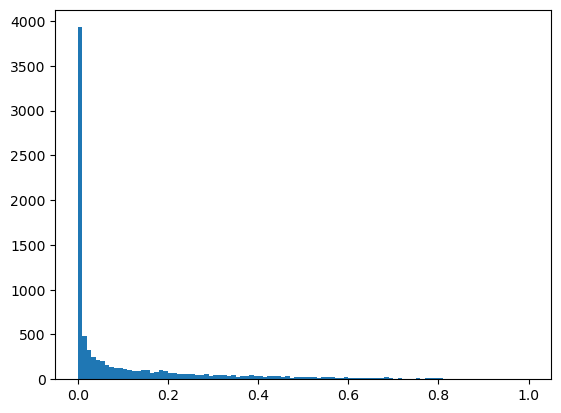

In [4]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

window_size = 20
threshold=0.1
with open(f'../fss_stats/fractions_{window_size}_{threshold}.pkl', 'rb') as ifh:
    fss_stats = pickle.load(ifh)

(n_samples, lat_length, lon_length) = fss_stats.shape

lat_index = random.choice(range(lat_length))
lon_index = random.choice(range(lon_length))

data = fss_stats[:, lat_index, lon_index]
plt.hist(data, bins=100)

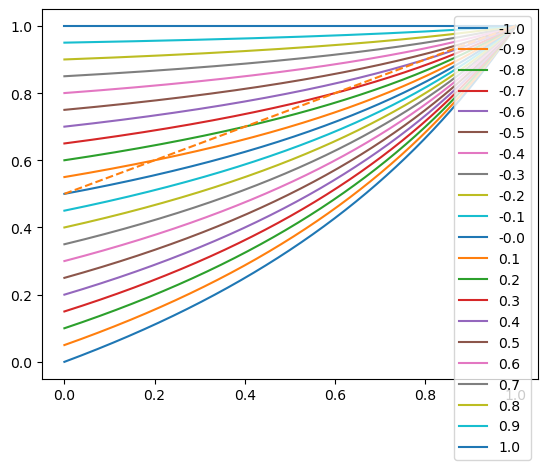

In [6]:
p = np.arange(0,1,0.001)

rho_vals = np.arange(-1, 1.1, 0.1)
c_vals = np.arange(1,50)

def fss(p, rho):
    fss_original = 0.5 + (p/2)*(1/(2-p))
    fss = fss_original + rho*(1-p)/(2-p)
    return fss, fss_original



fss_dict = {n: [fss(item, rho_vals[n])[0] for item in p] for n in range(len(rho_vals))}
fss_dict_with_c = {n: [fss(item, c_vals[n])[0] for item in p] for n in range(len(c_vals))}

for n, fss_vals in fss_dict.items():
    plt.plot(p, fss_vals, label=f'{rho_vals[n]:.1f}')
plt.plot(p, [0.5 + item/2 for item in p], '--') 
plt.legend()

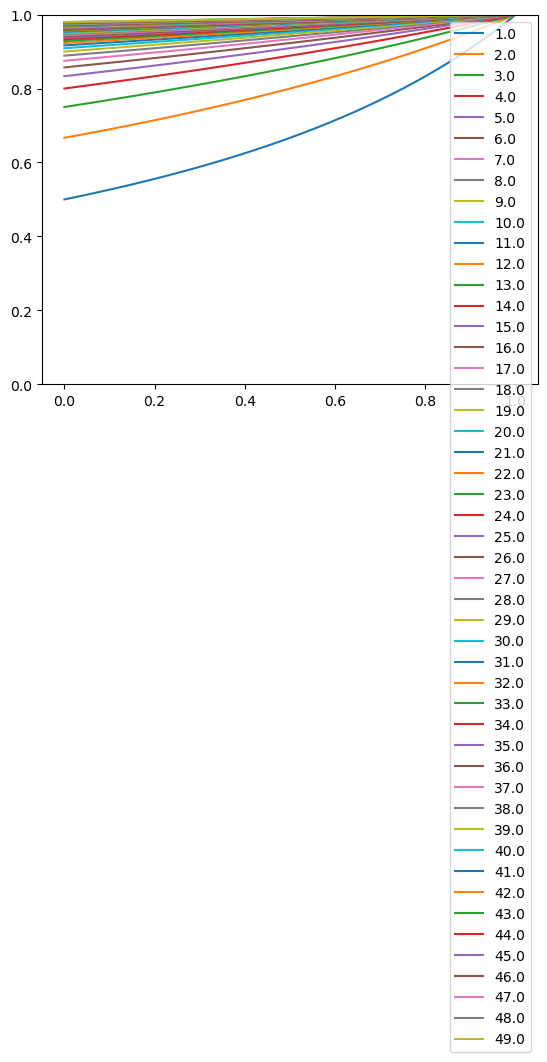

In [7]:
def fss_with_c(p, c):
    fss = 0.5 +(c - 1 + p)/(2 * (c+1-p))
    return fss
fss_dict_with_c = {n: [fss_with_c(item, c_vals[n]) for item in p] for n in range(len(c_vals))}
for n, fss_vals in fss_dict_with_c.items():
    plt.plot(p, fss_vals, label=f'{c_vals[n]:.1f}')
    plt.ylim([0, 1])
plt.legend()

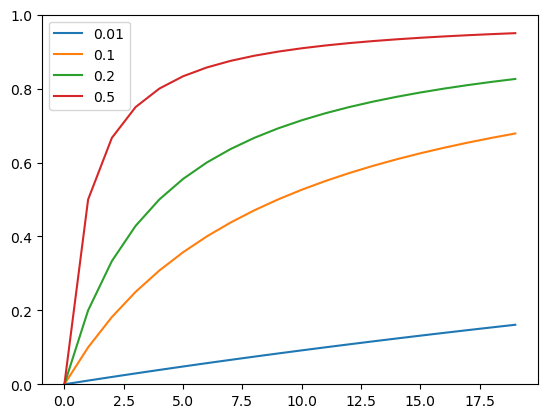

In [21]:
# The expected value at a particular window size, with zere correlation
p = 0.01

nrange = np.arange(0, 20)

for p in [0.01, 0.1, 0.2, 0.5]:
    fss_threshold = [(n*p) / (n*p -p + 1) for n in nrange]

    plt.plot(nrange, fss_threshold, label=p)
    plt.ylim([0,1])
plt.legend()

In [4]:
import numpy as np
import os
import sys
from pathlib import Path

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))


truth_array = np.load('truth_array.npy')
fcst_array = np.load('fcst_array.npy')
samples_ensmean_array = np.load('samples_ensmean_array.npy')


In [5]:

def calculate_fss(truth_array, fcst_array, threshold, min_window_size=1, max_window_size=50):
    
    
    (n_samples, height, width) = truth_array.shape
    fss = {}
    fractions_truth_mean = {}
    fractions_fcst_mean = {}
    
    fractions_truth_std = {}
    fractions_fcst_std = {}
    
    lower_bound = {}

    for window_size in np.arange(min_window_size, max_window_size):

        num_windows_h = int(height / window_size)
        num_windows_w = int(width / window_size)

        fractions_truth = []
        fractions_fcst = []
        for n in range(n_samples):
            
            truth_data = truth_array[n, :, :]
            fcst_data = fcst_array[n, :, :]
            
            for h_window in range(num_windows_h):
                for w_window in range(num_windows_w):
                    
                    truth_window = truth_data[h_window*window_size:(h_window+1)*window_size, w_window*window_size:(w_window+1)*window_size]
                    truth_fraction = np.nansum(truth_window > threshold) / (window_size**2)
                    fractions_truth.append(truth_fraction)
                    
                    fcst_window = fcst_data[h_window*window_size:(h_window+1)*window_size, w_window*window_size:(w_window+1)*window_size]
                    fcst_fraction = (fcst_window > threshold).sum() / (window_size**2)
                    fractions_fcst.append(fcst_fraction)
                    
        fractions_truth = np.array(fractions_truth)
        fractions_fcst = np.array(fractions_fcst)
        
        fractions_truth_mean[window_size] = fractions_truth.mean()
        fractions_fcst_mean[window_size] = fractions_fcst.mean()
        
        fractions_truth_std[window_size] = fractions_truth.std()
        fractions_fcst_std[window_size] = fractions_fcst.std()
            
        fss[window_size] = 2*(fractions_truth*fractions_fcst).sum() / (np.power(fractions_truth, 2).sum() + np.power(fractions_fcst, 2).sum())
        
        lower_bound[window_size] = 2*fractions_truth_mean[window_size]**2 / (2*fractions_truth_mean[window_size]**2 + 2*fractions_truth_std[window_size]**2 )

    return fss, (fractions_truth_mean, fractions_truth_std), (fractions_fcst_mean, fractions_fcst_std), lower_bound
    



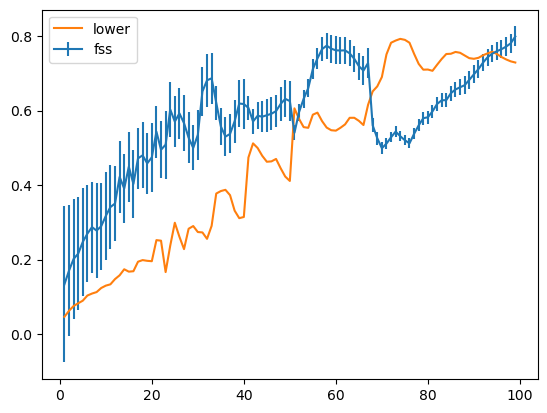

In [7]:
fss_dict, (fractions_truth_mean, fractions_truth_std), (fractions_fcst_mean, fractions_fcst_std), lower_bound= calculate_fss(truth_array=truth_array, fcst_array=fcst_array, threshold=0.1, max_window_size=100)

import matplotlib.pyplot as plt

plt.errorbar(fss_dict.keys(), fss_dict.values(), yerr = list(fractions_truth_std.values()), label='fss')
plt.plot(lower_bound.keys(), lower_bound.values(), label='lower')
plt.legend()

In [6]:
from scipy.ndimage import uniform_filter

def fss_pysteps( fcst_array, obs_array, scale, thr):

    """Accumulate ensemble forecast-observation pairs to an FSS object.
    Does ensemble mean of thresholded arrays.
    Parameters
    -----------

    X_f: array_like
        Array of shape (s,  m, n) containing an ensemble of c forecast fields.
    X_o: array_like
        Array of shape (s, m, n) containing the observation field.
    """
    if fcst_array.shape != obs_array.shape:
        message = "X_f and X_o must havethe same image dimensions"
        raise ValueError(message)

    sum_obs_sq = 0
    sum_fct_obs = 0
    sum_fct_sq = 0
    
    obs_filtered = []
    fcst_filtered = []

    for n in range(obs_array.shape[0]):
        X_o = truth_array[n, :, :]
        X_f = fcst_array[n, :, :]

        # Convert to binary fields with the given intensity threshold
        I_f = (X_f >= thr).astype(np.single)
        I_o = (X_o >= thr).astype(np.single)

        # Compute fractions of pixels above the threshold within a square
        # neighboring area by applying a 2D moving average to the binary fields
        if scale > 1:
            S_f = uniform_filter(I_f, size=scale, mode="constant", cval=0.0)
            S_o = uniform_filter(I_o, size=scale, mode="constant", cval=0.0)
        else:
            S_f = I_f
            S_o = I_o

        
        sum_obs_sq += np.nansum(S_o ** 2)
        sum_fct_obs += np.nansum(S_f * S_o)
        sum_fct_sq += np.nansum(S_f ** 2)
    
    numer = sum_fct_sq - 2.0 * sum_fct_obs + sum_obs_sq
    denom = sum_fct_sq + sum_obs_sq

    return 1.0 - numer / denom, S_f, S_o

In [16]:
from tqdm import tqdm

threshold_vals = [0.01, 0.1, 0.15, 0.2, 0.25]
window_range = range(1,truth_array.shape[1])

p_truth = []
fcst_results = []
ensmean_results = []
random_fcsts = []
lb = []
corr = []

def lower_bound(mu_obs, mu_f, sigma_obs, sigma_f):
    return (2*mu_obs*mu_f)/(mu_obs**2 + mu_f**2 + sigma_obs**2 + sigma_f**2)

def correlation(fss, mu_obs, mu_f, sigma_obs, sigma_f):
    lb = (2*mu_obs*mu_f)/(mu_obs**2 + mu_f**2 + sigma_obs**2 + sigma_f**2)
    return (fss - lb) * (mu_obs**2 + mu_f**2 + sigma_obs**2 + sigma_f**2) / (2*sigma_f*sigma_obs)
    
for threshold in tqdm(threshold_vals, total=len(threshold_vals)):
    p_truth.append((truth_array > threshold).mean())
    fcst_result = [fss_pysteps( fcst_array, truth_array, n, threshold) for n in window_range]
    fcst_results.append(fcst_result)
    ensmean_results.append([fss_pysteps( samples_ensmean_array, truth_array, n, threshold) for n in window_range])

    fcst_mu = {n: fcst_result[ix][1].mean() for ix, n in enumerate(window_range)}
    fcst_sigma = {n: fcst_result[ix][1].std() for ix, n in enumerate(window_range)}

    obs_mu = {n: fcst_result[ix][2].mean() for ix, n in enumerate(window_range)}
    obs_sigma = {n: fcst_result[ix][2].std() for ix, n in enumerate(window_range)}
    
    lb.append([lower_bound(obs_mu[n], fcst_mu[n], obs_sigma[n], fcst_sigma[n]) for n in window_range])
    corr.append([correlation(fcst_result[n-1][0], obs_mu[n], fcst_mu[n], obs_sigma[n], fcst_sigma[n]) for n in window_range])

 60%|██████    | 3/5 [01:40<01:07, 33.57s/it]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


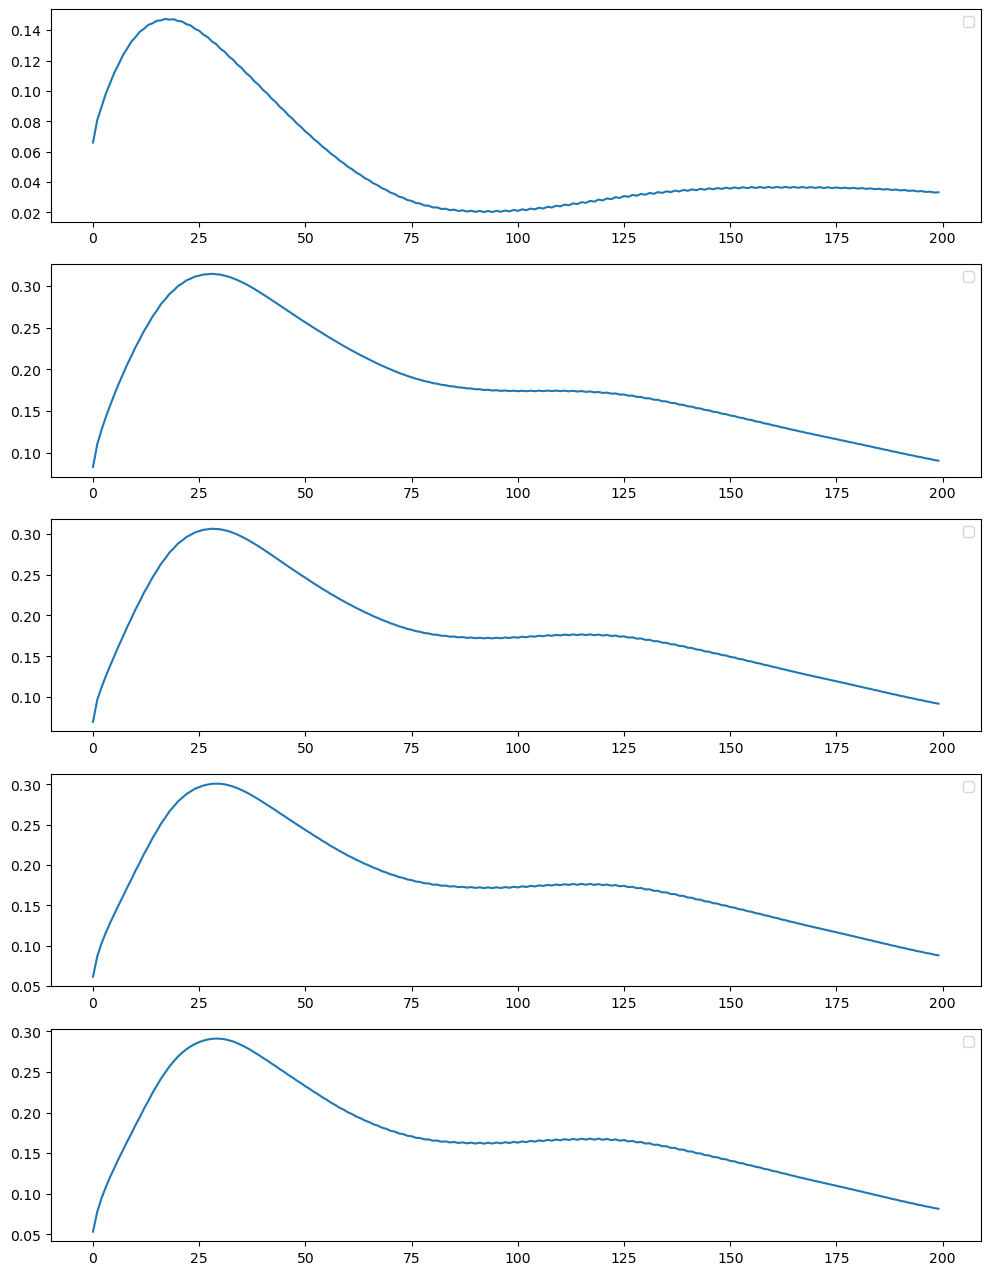

In [12]:


fig, axs = plt.subplots(len(threshold_vals), 1, figsize=(12,16))

for p_n, threshold in enumerate(threshold_vals):
    
    fcst_fss = [item[0] for item in fcst_results[p_n]]
    axs[p_n].plot(corr[p_n])
    # axs[p_n].plot([fcst_fss[m] - lb[p_n][m] for m in range(len(fcst_fss))])
    # axs[p_n].plot(fcst_fss, label='ifs')

    # axs[p_n].plot([item[0] for item in fcst_results[p_n]], label='ifs')
    # axs[p_n].plot([item[0] for item in ensmean_results[p_n]], label='cGAN ensemble')
    # axs[p_n].plot([0.5 + 0.05/2]*len(fcst_results[p_n]))
    
    
    # axs[p_n].plot(lb[p_n], label='lb')
    # axs[p_n].plot(lb_2[p_n], '--', label='lb2')
    # axs[p_n].plot([(p_truth[p_n])/(1+p_truth[p_n])]*len(fcst_results[p_n]), label='uniform')
    # plt.plot()
    axs[p_n].legend()

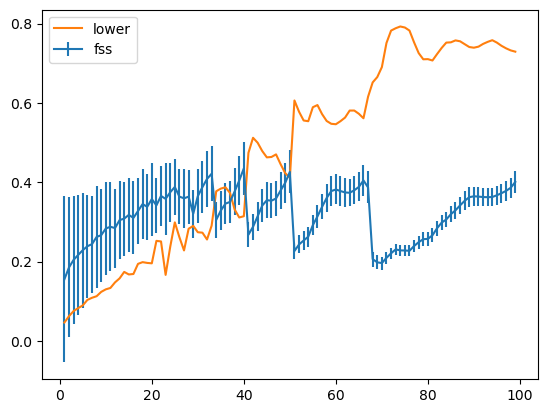

In [44]:
fss_dict, (fractions_truth_mean, fractions_truth_std), (fractions_fcst_mean, fractions_fcst_std), lower_bound= calculate_fss(truth_array=truth_array, fcst_array=samples_ensmean_array, threshold=0.1, max_window_size=100)

import matplotlib.pyplot as plt

plt.errorbar(fss_dict.keys(), fss_dict.values(), yerr = list(fractions_truth_std.values()), label='fss')
plt.plot(lower_bound.keys(), lower_bound.values(), label='lower')
plt.legend()